In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

In [9]:
def add_noise(image):  
    noise_type = tf.random.uniform([], 0, 1)  
    
    if noise_type < 0.4:  
        noise = tf.random.normal(tf.shape(image), mean=0.0, stddev=0.03)  
        image = image + noise  
    elif noise_type < 0.7:  
        mask = tf.random.uniform(tf.shape(image)) < 0.05  
        noise = tf.random.uniform(tf.shape(image))  
        image = tf.where(mask, noise, image)  
    
    return tf.clip_by_value(image, 0.0, 1.0) 
def logarithmic_transform(image):  
    image = tf.clip_by_value(image, 0.0, 1.0)  
    image = tf.math.log1p(image)  
    image = image / tf.math.log(2.0)  
    return image
        
def gamma_transform(image, gamma=1.0):  
    image = tf.clip_by_value(image, 0.0, 1.0)  
    image = tf.math.pow(image, gamma)  
    return image


def advanced_preprocessing(image): 
    if tf.random.uniform([]) > 0.5:  
        image = logarithmic_transform(image)  

    if tf.random.uniform([]) > 0.5:  
        gamma = tf.random.uniform([], 0.8, 1.2)
        image = gamma_transform(image, gamma)  
    if tf.random.uniform([]) > 0.7:  
        image = add_noise(image) 
        
    return tf.clip_by_value(image, 0.0, 1.0)  

In [10]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   preprocessing_function=advanced_preprocessing,
                                   validation_split = 0.2,
                                  
        rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        #zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

test_datagen  = ImageDataGenerator(rescale = 1./255
                                  )

In [11]:
train_dataset  = train_datagen.flow_from_directory(directory = 'train',
                                                   target_size = (48,48),
                                                   class_mode = 'categorical',
                                                   subset = 'training',
                                                   batch_size = 64)

Found 6547 images belonging to 7 classes.


In [12]:
valid_dataset = valid_datagen.flow_from_directory('train',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  subset = 'validation',
                                                  batch_size = 64)

Found 1636 images belonging to 7 classes.


In [13]:
test_dataset = test_datagen.flow_from_directory(directory = 'test',
                                                  target_size = (48,48),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 7178 images belonging to 7 classes.


(48, 48, 3)
(1, 48, 48, 3)


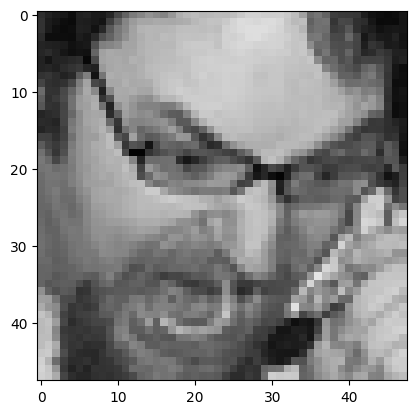

In [14]:
from keras.preprocessing import image
img = image.load_img("test/angry/PrivateTest_10131363.jpg",target_size=(48,48))
img = np.array(img)
plt.imshow(img)
print(img.shape)

img = np.expand_dims(img, axis=0)
from keras.models import load_model
print(img.shape)

In [15]:
base_model = tf.keras.applications.ResNet50(input_shape=(48,48,3),include_top=False,weights="imagenet")

2024-11-05 18:13:35.992064: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [16]:
for layer in base_model.layers[:-4]:
    layer.trainable=False

In [17]:
model=Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(7,activation='softmax'))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 2, 2, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 batch_normalization (Batch  (None, 8192)              32768     
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 32)                262176    
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                       

In [19]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = ModelCheckpoint('model.h5')

es = EarlyStopping(verbose=1, patience=20)

model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=METRICS)

history=model.fit(train_dataset,validation_data=valid_dataset,epochs = 60,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/60
103/103 [==============================] - ETA: 0s - loss: 2.0945 - accuracy: 0.8476 - precision: 0.2226 - recall: 0.0267 - auc: 0.5803 - f1_score: 0.0464

/home/jorge04/.local/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


103/103 [==============================] - 45s 408ms/step - loss: 2.0945 - accuracy: 0.8476 - precision: 0.2226 - recall: 0.0267 - auc: 0.5803 - f1_score: 0.0464 - val_loss: 1.4020 - val_accuracy: 0.8573 - val_precision: 1.0000 - val_recall: 0.0012 - val_auc: 0.8817 - val_f1_score: 0.0024 - lr: 0.0010
Epoch 2/60
103/103 [==============================] - 17s 163ms/step - loss: 1.2144 - accuracy: 0.8547 - precision: 0.4757 - recall: 0.1677 - auc: 0.8818 - f1_score: 0.2437 - val_loss: 1.1557 - val_accuracy: 0.8571 - val_precision: 0.4444 - val_recall: 0.0024 - val_auc: 0.9032 - val_f1_score: 0.0047 - lr: 0.0010
Epoch 3/60
103/103 [==============================] - 17s 165ms/step - loss: 1.0212 - accuracy: 0.8549 - precision: 0.4851 - recall: 0.2613 - auc: 0.8962 - f1_score: 0.3383 - val_loss: 1.1611 - val_accuracy: 0.8470 - val_precision: 0.4635 - val_recall: 0.4505 - val_auc: 0.8889 - val_f1_score: 0.4559 - lr: 0.0010
Epoch 4/60
103/103 [==============================] - 17s 166ms/step 

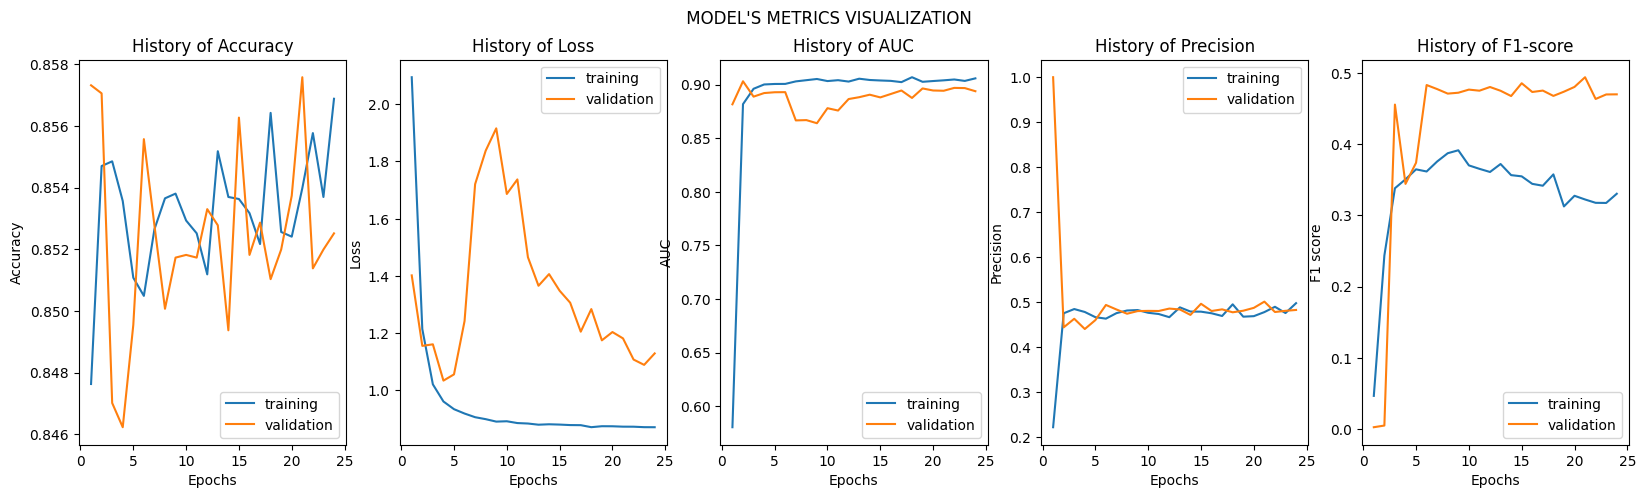

In [21]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(history.history['accuracy'],history.history['val_accuracy'],
               history.history['loss'],history.history['val_loss'],
               history.history['auc'],history.history['val_auc'],
               history.history['precision'],history.history['val_precision'],
               history.history['f1_score'],history.history['val_f1_score']
              )

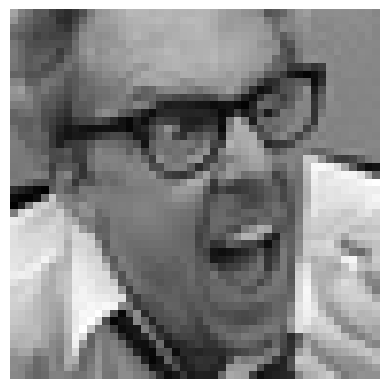

1/1 [==============================] - 0s 467ms/step
La imagen pertenece a la clase: 2


In [27]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Cargar el modelo previamente entrenado
model = load_model('model.h5', custom_objects={'f1_score': f1_score})

# Función para cargar y preprocesar la imagen
def load_and_preprocess_image(img_path, target_size=(48, 48)):  # Cambiar a (48, 48)
    # Cargar la imagen y redimensionarla
    img = image.load_img(img_path, target_size=target_size)
    # Mostrar la imagen
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    
    # Convertir la imagen a array y normalizarla
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  
    img_array /= 255.0  # Normalización

    return img_array

# Ruta de la imagen de prueba
img_path = 'prueba.jpg'

# Cargar y preprocesar la imagen
input_image = load_and_preprocess_image(img_path, target_size=(48, 48))

# Realizar la predicción
predictions = model.predict(input_image)

# Obtener la clase predicha
predicted_class = np.argmax(predictions, axis=-1)

# Imprimir la clase predicha
print(f'La imagen pertenece a la clase: {predicted_class[0]}')
